# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 4 — Gaussians

---

Submission by:
* FirstName1, Surname1, Matrikelnummer: MatrikelnummerOfFirstTeamMember
* FirstName2, Surname2, Matrikelnummer: MatrikelnummerOfSecondTeamMember

# Exercise 4.1 (Theory Exercise: Automated Trading) 

You have been hired to run a (terribly simplistic) hedge fund. You have a total budget of $B$ to spend on two kinds of stock packets: oil futures and the stock of airlines. Over the past years, average returns on oil futures were $5\%$ with a standard deviation of $8\%$, while airline stock has risen by $2\%$ on average, with a standard deviation of $4\%$. But oil futures and airline stock are anticorrelated: If one rises, the other tends to fall. Their covariance is $−4.5\%$. In other words, the joint distribution of their returns $r_{oil}$ and $r_{air}$ is approximately Gaussian, 

$$
p(r_{oil}, r_{air}) = \mathcal{N}
\left[
     \begin{pmatrix} r_{oil} \\ r_{air} \end{pmatrix}; 
     \begin{pmatrix} 0.05 \\ 0.02 \end{pmatrix}, 
     \begin{pmatrix} 0.080 & -0.045 \\ -0.045 & 0.040 \end{pmatrix} 
    \right]
$$


You can distribute your total budget $B$ into oil ($x$) and airlines $(B - x)$ into 
position with return $R = x r_{oil} + (B-x)$ 

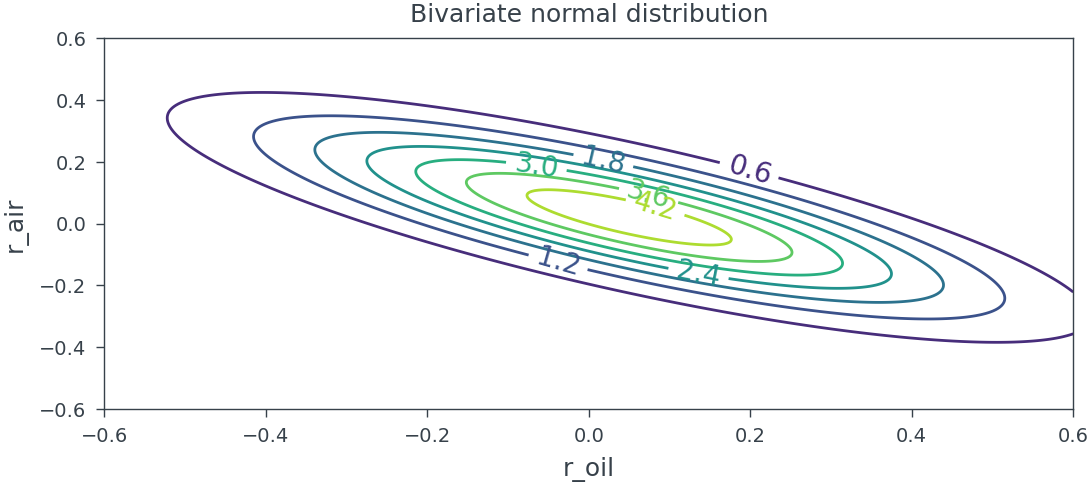

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Define mean vector and covariance matrix
mu = np.array([0.05, 0.02])
cov = np.array([[0.080, -0.045], [-0.045, 0.040]])

# Create grid of values for r_oil and r_air
r_oil = np.linspace(-0.6, 0.60, 300)
r_air = np.linspace(-0.6, 0.60, 300)
r_oil, r_air = np.meshgrid(r_oil, r_air)
pos = np.empty(r_oil.shape + (2,))
pos[:, :, 0] = r_oil
pos[:, :, 1] = r_air

# Evaluate bivariate normal PDF at each point on the grid
rv = multivariate_normal(mu, cov)
pdf = rv.pdf(pos)

# Create contour plot of PDF
fig, ax = plt.subplots()
contour = ax.contour(r_oil, r_air, pdf)
ax.clabel(contour, inline=True, fontsize=10)
ax.set_xlabel('r_oil')
ax.set_ylabel('r_air')
ax.set_title('Bivariate normal distribution')
plt.show()

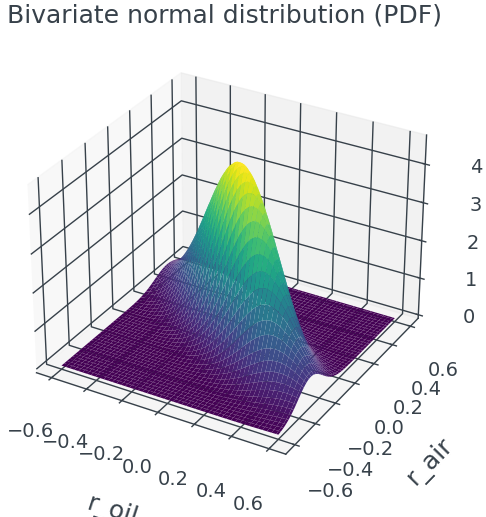

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

# Define mean vector and covariance matrix
mu = np.array([0.05, 0.02])
cov = np.array([[0.080, -0.045], [-0.045, 0.040]])

# Create grid of values for r_oil and r_air
r_oil = np.linspace(-0.6, 0.6, 100)
r_air = np.linspace(-0.6, 0.6, 100)
r_oil, r_air = np.meshgrid(r_oil, r_air)
pos = np.empty(r_oil.shape + (2,))
pos[:, :, 0] = r_oil
pos[:, :, 1] = r_air

# Evaluate bivariate normal PDF at each point on the grid
rv = multivariate_normal(mu, cov)
pdf = rv.pdf(pos)

# Create 3D plot of PDF
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(r_oil, r_air, pdf, cmap='viridis')
ax.set_xlabel('r_oil')
ax.set_ylabel('r_air')
ax.set_zlabel('PDF')
ax.set_title('Bivariate normal distribution (PDF)')
plt.show()


#### (a) What is the marginal predictive distribution $p(R)$ under this model ?


We note that that the $R$ is a linear combination of the components of the normal distrubtion 
$$\mathcal{N}\left[ \begin{pmatrix} r_{oil} \\ r_{air} \end{pmatrix}; \begin{pmatrix} 0.05 \\ 0.02 \end{pmatrix}, \begin{pmatrix} 0.08 & -0.045 \\ -0.045 & 0.040\end{pmatrix} \right]$$

Where we have 
$R = x r_{oil} + (B - x) r_{air}$ can be written as $R = \phi(x)^T \begin{bmatrix} r_{oil} \\ r_{air} \end{bmatrix}$ and $\phi(x) = \begin{bmatrix} x \\  B - x \end{bmatrix}$

Thus the marginal predictive distribution of $p(R)$ is given as 

$$
p(R) = \mathcal{N}(R, \phi_x^T \mu_o , \phi_x^T \Sigma_o \phi_x)
$$
Where $\mu_0$ and $\Sigma_0$ are the mean and covariance of the original distribution.

Thus $\mu_R = \phi_x^T \mu_o$ can be simplified and computed as:

$$ \mu_R = \begin{bmatrix} x & (B - x) \end{bmatrix} \begin{bmatrix} 0.05 \\ 0.02 \end{bmatrix} $$

 which simplifies to one dimensional mean of :

$$ \mu_R = (0.05) x + (0.02) (B-x) = ( 0.03)x + 0.02 B $$

#### (b) How would you chose the split $x$ to maximize expected return $\mathbb{E}[R]$ ?

The exected value of $\mathbb{E}[R]$ is maximized at the mean of the distribution. Thus we must maximize $\mu_R$ subject to 
the constraint that $x + (B - x) \leq = 0$. The maximum achievable value of $x$ is thus $B$ assuming $B-x = 0$ then we have


$$ \mathbb{E}[R] = 0.03B + 0.02B = 0.05B$$

#### (c) How would you chose $x$ to minimize variance $\mathbb{E}[R^2] - E[R^2]$ ?


Applying the linear transformation we know that the variance of $p(R)$ is given by
$\Sigma_r = \phi_x^T \Sigma \phi_x$ this is a one dimensional quantity which 
we choose to minimize, subject to $0 \leq x \leq B$.

$$\mathbb{E}[R^2] - \mathbb{E}[R^2] = \sigma_{r}^2 = \phi_x^T \Sigma \phi_x$$


Here we have:

$$\sigma_{r}^2 = \begin{bmatrix} x & (B - x) \end{bmatrix}  \begin{pmatrix} 0.08 & -0.045 \\ -0.045 & 0.04\end{pmatrix} \begin{bmatrix} x \\ (B - x) \end{bmatrix} $$

Simplying from the right to left we get: 

 $$\sigma_{r}^2 = \begin{bmatrix} x & (B - x) \end{bmatrix}  \begin{pmatrix} 0.08x + 0.045 x - 0.045 B \\ -0.045x + 0.04B - 0.04x  \end{pmatrix}   = \begin{bmatrix} x & (B - x) \end{bmatrix}  \begin{pmatrix} 0.125x - 0.045B  \\ -0.085x + 0.04B \end{pmatrix}  $$

 Simplifying further we get the one-dimensional variance by combining the like terms 

 $$\sigma_r^2 = x(0.125x - 0.45B) + (B- x) (-0.085x + 0.040B)  = (0.125 + 0.085)x^2 - Bx(0.045 + 0.085 + 0.04) - 0.04B^2$$

We get

$$\sigma_r^2 = 0.21x^2 - 0.17 Bx - 0.04 B^2 $$ 
which needs to be minimized subject to the constraint $0 \leq x \leq B$.

#### (d) For $B=1$ which split $x$ maximizes expected return if the expected variance of the portfolio is to be below $3\%$ ?


#### (e) Your fund is marketed to risk-averse customers, you must maximize the probability that the return is positive. What is the optimal split $x$ ? 


#### (f) Your colleagues in the quant department have built a smart model that analyses online news reports from the tourism industry to predict the development of the airline stock. The new model predicts that the airline stock will rise by $3\%$ this year, with the standard deviation $2\%$ (the model can be considered independent of historical data). Given this new information, what is your prediction for the development of oil futures this year?

In [100]:
import jax.numpy as jnp
import logging

from jax import random
key = random.PRNGKey(0)
from exponential_families import *
from tueplots import bundles
from matplotlib import pyplot as plt
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 200})

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

## Exercise 4.2 (Coding Exercise)

> This week's Exercise is directly taken from Exercise 24.3. of [David JC MacKay](https://en.wikipedia.org/wiki/David_J._C._MacKay)'s [*Information Theory, Inference, and Learning Algorithms*](http://www.inference.org.uk/mackay/itila/). (But don't waste your time trying to find an answer there :)

The terribly important quantity $\mu$ has been experimentally measured by seven scientists (A, B, C, D, E, F, G) with wildly differing experimental skills. They have reported the following measurements:

In [101]:
# We assume the same latent quantity $\mu$ for all observations.
X = jnp.array([-27.020,3.570,8.191,9.898,9.603,9.945,10.056])

Text(0.5, 0, 'measured value of $x$')

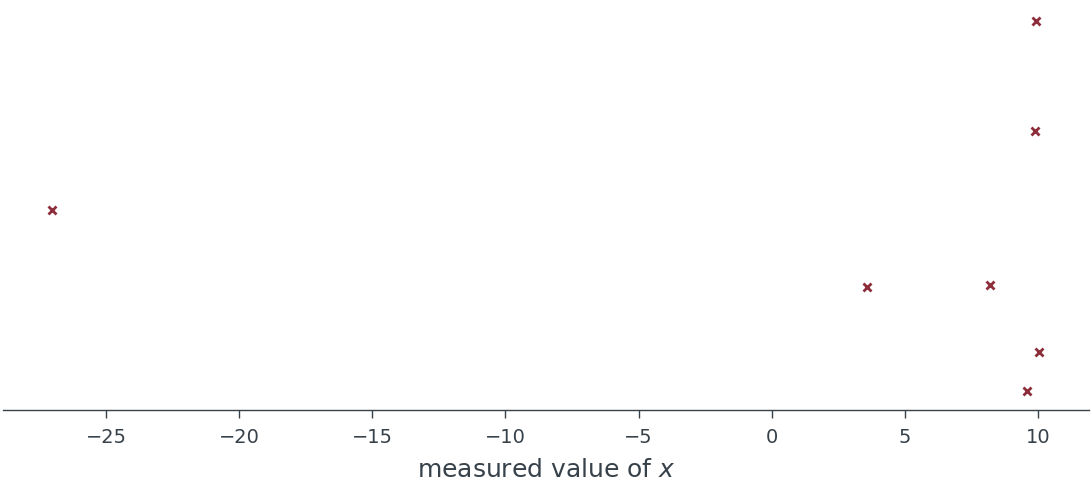

In [102]:
fig,ax = plt.subplots(1,1)
ax.plot(X,random.uniform(key, shape=(7,)),'x',ms=3)

ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('measured value of $x$')

We assume that they have all, independently of each other, made an unbiased Gaussian measurement of $\mu$: 
$$p(\boldsymbol{x}\mid \mu,\boldsymbol{\sigma}) = \prod_{i=1} ^7 \mathcal{N}(x_i;\mu,\sigma_i ^2).$$ 
But we have to assume that their measurement errors $\sigma_i$ vary a lot (some are skilled experimentalists, others are unqualified). 

#### Task A: 
Implement the likelihood above as a single jax function (this is unfortunately a case where our neat `ExponentialFamily` base class is more awkward than useful). Try using a numerical optimizer to find *maximum likelihood estimators*, i.e. points $(\mu, \vec{\sigma})$ that maximize this function. Alternatively, you can try and identify such points directly by inspecting the likelihood by hand.
  
You probably agree that, intuitively, it looks pretty certain that A and B are both inept measurers, that D–G are better, and that the true value of $\mu$ is somewhere close to $10$. Are your findings consistent with this intuition?  

In [144]:
import jax
import jax.numpy as jnp
import jax.scipy.optimize as optimize

# Step 1: Define log-likelihood function
def negative_log_likelihood(params, data):
    mean = params[0]
    std_deviations = params[1:]
    log_probs = [0  for _ in range(data.shape[0])]
    for i in range(data.shape[0]):
        log_probs[i] = jax.scipy.stats.norm.logpdf(data[i], loc=mean, scale=std_deviations[i])
        #print("data", data, "log_probs[i]", log_probs[i]," i=", i)
    return -jnp.sum(jnp.array(log_probs))

# Step 3: Initialize parameters and data, we find that the standard-deviation 
# does not have much data to deviate from the initialization, But the mean is 
# is close to 10 as was expected from the plot above.
initial_params = jnp.array([10, -1.0, 1.0, 1.0, 1.0,1.0, 1.0])  # Initial guess for mean and standard deviation
data = X  # Your measurements as an array-like object

# Step 4: Minimize the negative log-likelihood
result = optimize.minimize(negative_log_likelihood, initial_params, args=(data,), method='BFGS')
estimated_params = result.x

print("Estimated Parameters (mean, std):", estimated_params)


data [-27.02    3.57    8.191   9.898   9.603   9.945  10.056] log_probs[i] Traced<ConcreteArray(-686.1591796875, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(-686.1592, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f8f44d2de50>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>, Traced<ConcreteArray(-2.0, dtype=float32):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x7f8fa1e87ba0; to 'JaxprTracer' at 0x7f8fa1e871f0>], out_avals=[ShapedArray(float32[])], primitive=div, params={}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f8f53cd1df0>, name_stack=NameStack(stack=(Transform(name='jvp'),))))  i= 0
data [-27.02    3.57    8.191   9.898   9.603   9.945  10.056] log_probs[i] Traced<ConcreteArray(-21.591388702392578, dtype=float32)>with<JVPTrace(level=2/0)>

#### Task B:
We will now instead provide a Bayesian answer. Let the prior on each $\sigma_i^{-2}$ be a broad [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution), i.e. the distribution
$$ \mathcal{G}(z;\alpha,\beta)=\frac{\beta^\alpha}{\Gamma(\alpha)} z^{\alpha-1} e^{-\beta z},$$
and
$$p(\boldsymbol{\sigma}) = \prod_{i=1} ^7 \mathcal{G}(\sigma_i^{-2};\alpha,\beta),$$ 
with, say, $\alpha=1$, $\beta=0.1$. 

Let the prior for $\mu$ be a broad Gaussian $p(\mu) = \mathcal{N}(\mu; m, v^2)$ with mean $m = 0$ and standard deviation $v = 10^3$. 

Find the posterior for $\mu$. Plot this posterior for $\mu$, both for the data given above and for $\boldsymbol{x} = \{13.01, 7.39\}$.


**Hint:** First, remember that the Gamma is the conjugate prior for the Gaussian with fixed mean $\mu$. The marginal $p(\boldsymbol{x}\mid\mu)$ can thus be computed using the `log_marginal_pdf` function you implemented generically for exponential families last week, and which has an analytic form. Then use Bayes' theorem a second time to find $p(\mu\mid\boldsymbol{x})$ up to normalization, by directly multiplying the prior for $\mu$ and the marginal likelihood terms you just found. 


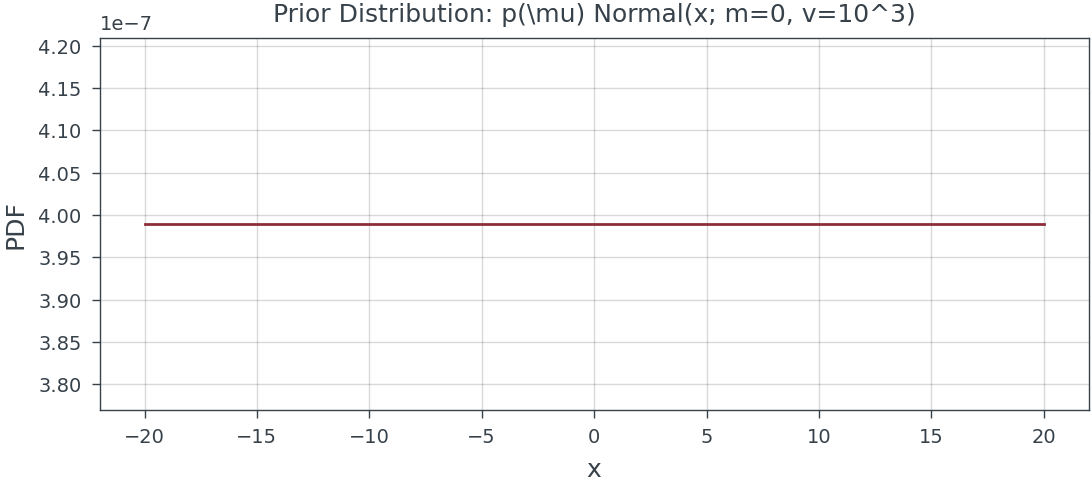

In [112]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Define the parameters of the normal distribution
m = 0.0  # Mean
v = 10**3.0  # Standard deviation

# Create a range of x values.
x = jnp.linspace(-20, 20, 500)

# Compute the probability density function (PDF) of the normal distribution
pdf = jax.scipy.stats.norm.pdf(x, loc=m, scale=v**2)

# Plot the PDF
plt.plot(x, pdf)
plt.xlabel('x')
plt.ylabel('PDF')
plt.title(r'Prior Distribution(Non-informative): p(\mu) Normal(x; m=0, v=10^3)')
plt.grid(True)
plt.show()

### 1. First, remember that the Gamma is the conjugate prior for the Gaussian with fixed mean $\mu$. The marginal $p(\boldsymbol{x}\mid\mu)$ can thus be computed using the `log_marginal_pdf` function you implemented generically for exponential families last week, and which has an analytic form.

1. Ok so Gamma is the conjugate prior for Gaussian with fixed mean $\mu$.
2. Compute $p(x | \mu) using the log-marginal-pdf function you implemented generically for exponential families. 


The log marginal function for exponential families is given by: 

$$
p(x | \mu ) = h(x)\frac{F(\phi(x) + \alpha, \nu + 1)}{F(\alpha, \nu)}
$$

In [118]:
# Plot the gamma prior with given values for \alpha and \beta
print("")

"""
def predictive_log_marginal_pdf(
    self,
    x: ArrayLike | jnp.ndarray,
    conjugate_natural_parameters: ArrayLike | jnp.ndarray,
) -> jnp.ndarray:
    --- Signature `(D),(P)->()`
        log p(x|conjugate_natural_parameters)
        Your answer to Part B below should be implemented here.
    ---
    # Implement $p(x) = h(x)\frac{F(\phi(x)+\alpha, \nu+1)}{F(\alpha, \nu)}$
    lbm = self.log_base_measure(x)
    st = self.sufficient_statistics(x) 
    alpha = conjugate_natural_parameters[:-1]
    nu =   conjugate_natural_parameters[-1]
    plm =  (lbm \
        + self.conjugate_log_partition(st + alpha, nu + 1))[...,0] \
        - self.conjugate_log_partition(alpha, nu)
    return plm
"""

how are you?


'\ndef predictive_log_marginal_pdf(\n    self,\n    x: ArrayLike | jnp.ndarray,\n    conjugate_natural_parameters: ArrayLike | jnp.ndarray,\n) -> jnp.ndarray:\n    --- Signature `(D),(P)->()`\n        log p(x|conjugate_natural_parameters)\n        Your answer to Part B below should be implemented here.\n    ---\n    # Implement $p(x) = h(x)\x0crac{F(\\phi(x)+\x07lpha, \nu+1)}{F(\x07lpha, \nu)}$\n    lbm = self.log_base_measure(x)\n    st = self.sufficient_statistics(x) \n    alpha = conjugate_natural_parameters[:-1]\n    nu =   conjugate_natural_parameters[-1]\n    plm =  (lbm         + self.conjugate_log_partition(st + alpha, nu + 1))[...,0]         - self.conjugate_log_partition(alpha, nu)\n    return plm\n'

### 2.  Then use Bayes' theorem a second time to find $p(\mu\mid\boldsymbol{x})$ up to normalization, by directly multiplying the prior for $\mu$ and the marginal likelihood terms you just found. 

We not attempt ot find the posterior for the distribution.

In [119]:
## Your answer here.
print("gamma!")
# p(\mu| x \propto p(x|\mu)p(\mu)

gamma!


### Thus the posterior for $\mu$ is given by x